In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
from yaml import safe_load
from pandas import read_csv, pivot_table, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Function = Exttract Required Database for Clustering

- **Purpose** = Read the CSV file from "../data/processed" and convert to dataframes for clustering.

- **Input** = File-name of processed data, and variable name

- **Output** = Two Dataframes for clustering analysis

    - 1st dataframe for mean of the given variable.

    - 2nd dataframe for standard deviation of the given variable.

In [3]:
# Function - Extract dataframe for clustering
def extract_df(fileName, var):
    global configDatabase
    
    # Read CSV file
    df = read_csv(fileName, compression='gzip')
    
    # Process the database
    df['month'] = df.monthID % 12
    df.month = df.month.replace(0, 12)
    df = df[['pos', 'month', var]]
    
    # Pivot table of database
    table = pivot_table(df, values=var, index=['pos', 'month'], aggfunc=["mean", "std"])
    table.reset_index(inplace=True)
    table.columns = ['pos', 'month', var+'_mean', var+'_std']
    
    # Create dataframe with months as columns
    dfMean = DataFrame(columns=['pos'] + [str(i+1) for i in range(12)])
    dfStd = DataFrame(columns=['pos'] + [str(i+1) for i in range(12)])
    for posVal in table.pos.unique():
        dfMean.loc[len(dfMean.index)] = [posVal] + table[table.pos == posVal][var + '_mean'].to_list()
        dfStd.loc[len(dfStd.index)] = [posVal] + table[table.pos == posVal][var + '_std'].to_list()
    
    return dfMean, dfStd

### Function - K-Means Clustering (Number of Cluster Identification)

- **Purpose** = Optimize the number of cluster and Build k_Means Cluster Model

- **Input** = The various inputs are

    - Rainflall (Mean or Standard Deviation) for 12 months

    - Starting number of cluster (must be greater than or equal to 2)

    - Ending number of cluster to search

    - Tuple containing latitude and longitude of each position

- **Output** = The various outputs are

    - Graph showcasing silhouette score vs number of clusters

    - Graph showcasing the cluster ID for different positions

    - K-Means Cluster model

In [4]:
# Function - Identify the number of cluster centers
def model_kmean_cluster(X, kStart, kEnd, posList):
    global configDatabase
    
    # Intialize Parameters
    kList = range(kStart, kEnd)
    silhouette = []
    for k in kList:
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=20, random_state=configDatabase['seed'])
        kmeans.fit(X)
        silhouette.append(silhouette_score(X, kmeans.labels_))
    print("Optimal Number of Cluster = ", np.argmax(silhouette) + 2)
    
    # Build Model for Optimal Cluster
    kmeans = KMeans(init='k-means++', n_clusters=np.argmax(silhouette) + 2, n_init=20, random_state=configDatabase['seed'])
    kmeans.fit(X)
    
    # Plot Silhouette Score and Clustered Data
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.plot(kList, silhouette)
    plt.grid(True)
    plt.xlabel("Number of Cluster")
    plt.ylabel("Silhouette Score")
    
    plt.subplot(1, 2, 2)
    lat = [float(i.replace('(','').replace(')', '').split(',')[0]) for i in posList]
    lon = [float(i.replace('(','').replace(')', '').split(',')[1]) for i in posList]
    plt.scatter(lon, lat, c=kmeans.labels_, cmap=cm.Accent)
    plt.grid(True)
    plt.xlabel("Latitude")
    plt.ylabel("Longitudinal")
    plt.tight_layout()
    plt.show()
    
    return kmeans

## MAIN CODE

Optimal Number of Cluster =  2


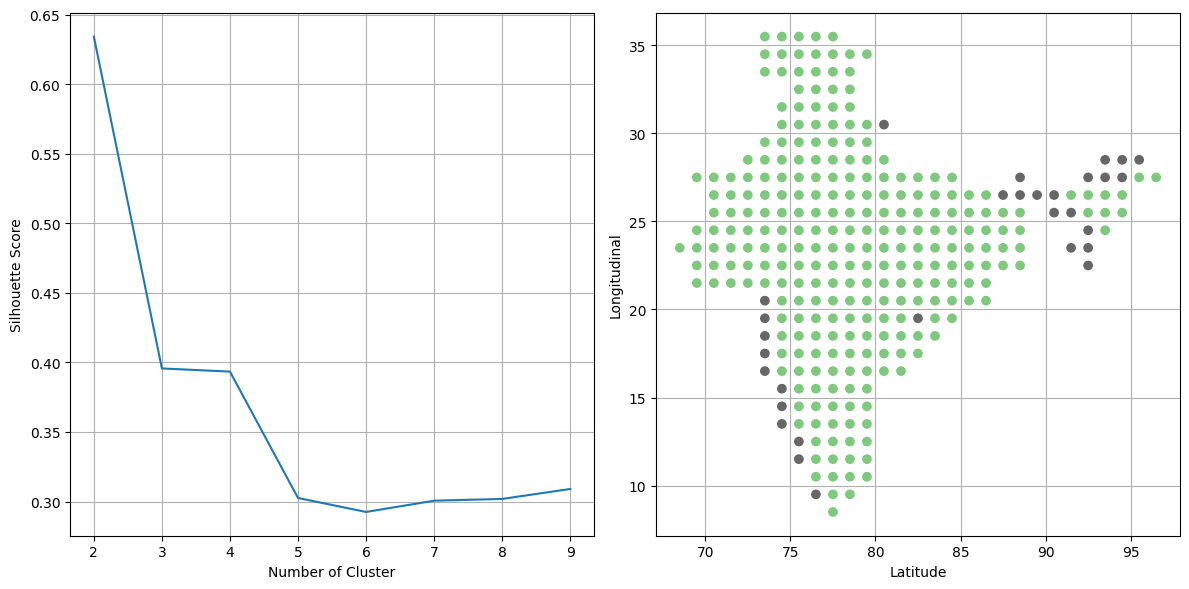

In [6]:
# Main Code
configDatabase = safe_load(open("../config.yaml"))
fileName = os.path.join(configDatabase['dir']['dataProcess'], configDatabase['file']['train02'])
var = 'rain_sum'

dfMean, dfStd = extract_df(fileName, var)

kmeans_mean = model_kmean_cluster(dfMean.iloc[:,1:].to_numpy(), configDatabase['clustering']['kstart'], configDatabase['clustering']['kend'], dfMean.pos)
#kmeans_std= model_kmean_cluster(dfStd.iloc[:,1:].to_numpy(), configDatabase['clustering']['kstart'], configDatabase['clustering']['kend'], dfStd.pos)
